# Explore taxon splitting

## Context

Content within a taxon may naturally cluster. These clusters could be the basis for splititng the taxon into more granular child taxons.

## Prepare workspace

Assuming for now that your working directory is at `/content-similarity-models/google-universal-encoder`

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import pairwise_distances, pairwise_distances_chunked

import altair as alt
from altair import datum
alt.renderers.enable('notebook')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

## Read and prepare data

There are a few data sets used here:

1. Content items and embeddings

    1a. Embedded clean content (pickle file)
    
    1b. Labelled data (data frame with a row per content item)
    
    1c. Embedded sentences (an array of the pairwise cosine similarity scores)
    
    
2. Branch homogeneity scores

### 1a. Embedded clean content (pickle file)

This pickle file was created to combine the content data with the embeddings with the need for the numpy array as per section '1. Embedded sentences'.

In [2]:
embedded_clean_content = pd.read_pickle('../data/embedded_clean_content.pkl')

In [3]:
embedded_clean_content.iloc[1]

base_path                          /government/statistics/uk-labour-market-statis...
content_id                                      a61985b0-d6eb-4cf1-8140-642b9557ce00
description                        employment unemployment economic inactivity cl...
document_type                                                    national_statistics
first_published_at                                     2017-05-17T08:30:02.000+00:00
locale                                                                            en
primary_publishing_organisation                       Office for National Statistics
publishing_app                                                             whitehall
title                                          uk labour market statistics: may 2017
body                               official statistics are produced impartially a...
combined_text                      uk labour market statistics: may 2017 employme...
embedded_sentences                 [-0.03585460036993027, 0.02925

### 1b. Labelled data (csv.gz)
We may also need to read the `labelled.csv` data to create some objects that will be used later. The labelled data is one of the inputs to the `get_homogeneity_scores_taxon.py script` that produces `taxon_homogeneity_df.csv`.

In [4]:
labelled = pd.read_csv(
    '../data/2019-02-11/labelled.csv.gz',
    compression = 'gzip',
    low_memory = False
)

In [5]:
labelled.iloc[1]

base_path                          /government/news/charity-commission-names-furt...
content_id                                      5fa49c52-7631-11e4-a3cb-005056011aef
description                            regulator increases transparency of its work.
document_type                                                          press_release
first_published_at                                     2014-06-04T23:00:00.000+00:00
locale                                                                            en
primary_publishing_organisation                               The Charity Commission
publishing_app                                                             whitehall
title                              charity commission names further charities und...
body                               the charity commission has today named further...
combined_text                      charity commission names further charities und...
taxon_id                                        668cd623-c7a8-415

Each content item can exist in more than one row; it might be tagged to more than one part of the taxonomy.

In [6]:
labelled.shape  # 306k rows

(305703, 19)

In [7]:
labelled.drop_duplicates('content_id').shape  # 208k rows when duplicates removed

(208261, 19)

Prepare some objects for later visualisation.

In [8]:
taxon_id_name = labelled[['taxon_id', 'taxon_name', 'level1taxon', 'level2taxon', 'level3taxon', 'level4taxon', 'level5taxon']].drop_duplicates()

### 1c. Embedded sentences (numpy array)

A numpy array of embeddings for content items. Superseded by reading embedded clean content file in section 1a.

In [9]:
embedded_sentences = np.load('../data/embedded_sentences2019-02-11.npy')

In [10]:
embedded_sentences.view()

array([[ 0.05357241,  0.00247775, -0.020976  , ..., -0.05675139,
         0.01268296,  0.01008949],
       [-0.04339019, -0.03241241,  0.00900179, ..., -0.04839829,
         0.03903588, -0.0553612 ],
       [-0.01541414,  0.04076389,  0.04761627, ...,  0.03003302,
         0.02379775, -0.06022731],
       ...,
       [ 0.0387876 ,  0.04077478,  0.04639488, ..., -0.05905833,
         0.00860474, -0.04581202],
       [-0.0426819 ,  0.02391836,  0.02524047, ..., -0.01499535,
         0.0110037 , -0.07002866],
       [ 0.0517485 , -0.01900592,  0.00853599, ..., -0.05199422,
        -0.02320959, -0.05730124]], dtype=float32)

### 2. Branch homogeneity scores
Homogeneity scores at a branch level. A Pandas data frame output from the `get_homogeneity_scores_taxon.py` script.

In [11]:
taxon_homogeneity_df = pd.read_csv("../data/taxon_homogeneity_df.csv")

In [12]:
taxon_homogeneity_df.shape

(1265, 9)

In [13]:
taxon_homogeneity_df.head()

,Unnamed: 0,taxon_id,taxon_size,mean_cosine_score,taxon_base_path,taxon_level,level1taxon,fewer_than_or_equal_5items,more_than_0_5_diversity
0,0,668cd623-c7a8-4159-9575-90caac36d4b4,5166,0.595490,/society-and-culture/community-and-society,2,Society and culture,0,1
1,246,f9e476ef-654d-41ec-97d9-2b6842d4361d,786,0.589025,/society-and-culture/sports-and-leisure,2,Society and culture,0,1
2,48,495afdb6-47be-4df1-8b38-91c8adb1eefc,8136,0.571510,/business-and-industry,1,Business and industry,0,1
3,833,fc5f468f-a3ba-4fde-9c1d-ed2dd17cfd82,31,0.571205,/housing-local-and-community/housing-local-ser...,3,"Housing, local and community",0,1
4,18,b29cf14b-54c6-402c-a9f0-77218602d1af,2333,0.569644,/society-and-culture/arts-and-culture,2,Society and culture,0,1


## Splits

### Dimensionality reduction

Prepare array for Brexit items.

In [14]:
brexit_embeddings = embedded_sentences[labelled['taxon_id'] == 'd6c2de5d-ef90-45d1-82d4-5f2438369eea']

In [15]:
brexit_embeddings

array([[-0.01384636,  0.01715001,  0.03606272, ..., -0.01534817,
         0.01647961, -0.05993748],
       [-0.04563793,  0.04127745, -0.00644559, ..., -0.03332986,
         0.04976409, -0.06276609],
       [-0.01084065, -0.00611237, -0.01730281, ...,  0.00154343,
         0.05014637, -0.06256321],
       ...,
       [-0.04382474,  0.00842297,  0.0089147 , ..., -0.02628383,
         0.05491083, -0.05879661],
       [-0.00030151, -0.05320191,  0.03599082, ..., -0.04575277,
         0.01496796, -0.04728961],
       [-0.0412386 , -0.02751214,  0.03315298, ..., -0.0589726 ,
        -0.00737035, -0.06045217]], dtype=float32)

#### PCA

Perform PCA for dimensionality reduction

In [64]:
pca_setup = PCA(n_components = 2)
pca_brexit = pca_setup.fit_transform(brexit_embeddings)
print('Explained variation per principal component: {}'.format(
    pca_setup.explained_variance_ratio_))

Explained variation per principal component: [0.13139991 0.0992742 ]


Add PCA axes to labelled data.

In [31]:
labelled_brexit = labelled[labelled['taxon_id'] == 'd6c2de5d-ef90-45d1-82d4-5f2438369eea'].copy()
labelled_brexit['pca-one'] = pca_brexit[:,0]
labelled_brexit['pca-two'] = pca_brexit[:,1] 

In [45]:
labelled_brexit.head(1)

,base_path,content_id,description,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,...,taxon_id,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,pca-one,pca-two
92002,/government/publications/citizens-rights-admin...,9bea14d9-a73c-4ff7-9956-83602e3e0d8e,details of the uk’s proposed administrative pr...,policy_paper,2017-11-07T13:19:00.000+00:00,en,Home Office,whitehall,citizens' rights: administrative procedures in...,this paper sets out further details on the adm...,...,d6c2de5d-ef90-45d1-82d4-5f2438369eea,/government/brexit,Brexit,Government,Brexit,NaN,NaN,NaN,0.082637,0.525657


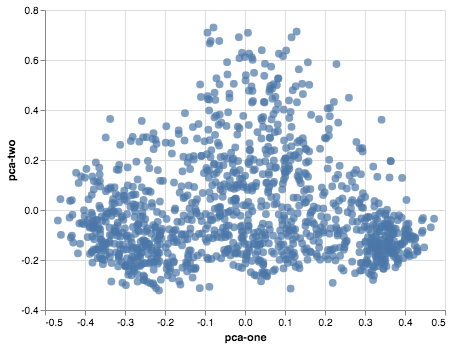

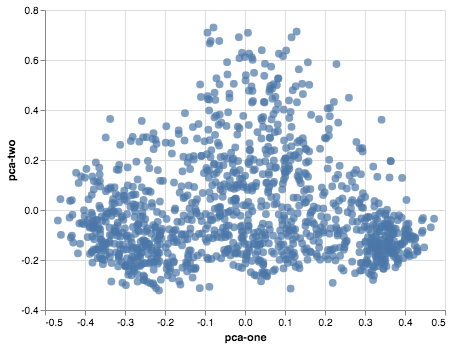

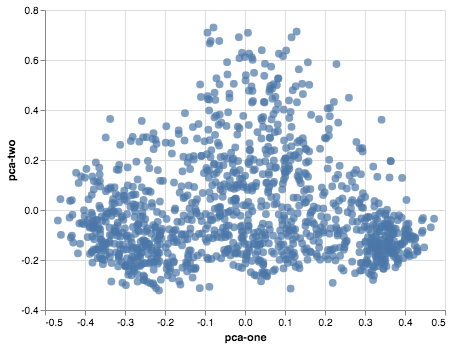

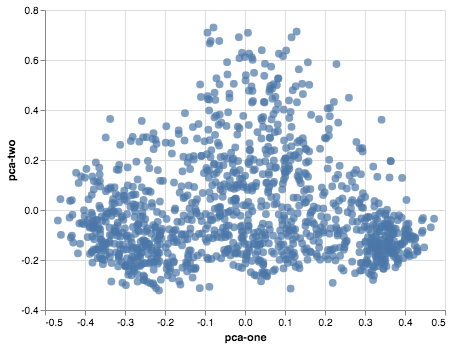

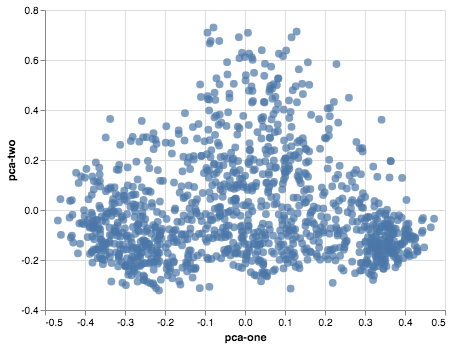

In [43]:
plot_brexit_pca = alt.Chart(
    labelled_brexit[['pca-one', 'pca-two', 'title']]
).mark_circle(size = 60).encode(
    alt.X('pca-one:Q'), 
    alt.Y('pca-two:Q'), 
    tooltip=['title:N'],
).interactive()

plot_brexit_pca.display()

In [116]:
labelled_brexit

,base_path,content_id,description,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,...,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,pca-one,pca-two,x-tsne,y-tsne
92002,/government/publications/citizens-rights-admin...,9bea14d9-a73c-4ff7-9956-83602e3e0d8e,details of the uk’s proposed administrative pr...,policy_paper,2017-11-07T13:19:00.000+00:00,en,Home Office,whitehall,citizens' rights: administrative procedures in...,this paper sets out further details on the adm...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.082637,0.525657,49.289139,12.681174
92003,/government/speeches/pm-press-conference-with-...,ac34fc44-11ef-40ad-aee6-69b0be39bed6,the prime minister gave a statement at a joint...,speech,2018-02-16T18:20:00.000+00:00,en,"Prime Minister's Office, 10 Downing Street",whitehall,pm press conference with chancellor merkel: 16...,chancellor merkel ladies and gentlemen we are ...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.318129,-0.103293,-11.730563,-50.619102
92004,/government/publications/response-to-the-house...,5fdc0a4d-7631-11e4-a3cb-005056011aef,this command paper sets out the government’s r...,policy_paper,2014-07-22T10:38:27.000+00:00,en,Foreign & Commonwealth Office,whitehall,response to the house of lords european union ...,the government welcomes the european union com...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.024974,0.098874,35.884884,15.286582
92005,/eu-withdrawal-act-2018-statutory-instruments/...,2516378a-418b-4004-9c7b-b398fc0d3d61,these instruments amend retained european unio...,statutory_instrument,2018-11-29T16:26:17.000+00:00,en,"Department for Environment, Food & Rural Affairs",specialist-publisher,the common agricultural policy (direct payment...,statutory instrument the common agricultural p...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.304190,-0.200286,-17.765965,80.257195
92006,/eu-withdrawal-act-2018-statutory-instruments/...,d738b3b8-9a3e-4aaa-b1a3-9b121dd90abf,the mutual recognition of protection measures ...,statutory_instrument,2018-10-22T18:44:40.000+00:00,en,Ministry of Justice,specialist-publisher,the mutual recognition of protection measures ...,sifting committees’ recommendation the sifting...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.304822,-0.207647,-4.094453,61.805122
92007,/government/publications/draft-money-launderin...,c824b48a-435d-4be9-b28f-0256ebf25e00,draft text of a statutory instrument which wil...,guidance,2018-11-13T12:31:33.000+00:00,en,HM Treasury,whitehall,draft money laundering and transfer of funds (...,this si will make amendments to retained eu la...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.320604,0.173663,11.889178,64.680016
92008,/guidance/get-a-uk-eori-number-to-trade-within...,59db06c8-e1b2-4e8c-8fc0-5a07e735a02c,uk businesses trading with the eu will need a ...,detailed_guide,2018-12-04T10:00:00.000+00:00,en,HM Revenue & Customs,whitehall,get a uk eori number to trade within the eu,overview in the event that the uk exits the eu...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.013317,0.102072,-9.229316,9.341375
92009,/eu-withdrawal-act-2018-statutory-instruments/...,5738835a-ad10-4d9e-8af0-72518ff897b8,these regulations enable the combined recognit...,statutory_instrument,2018-12-18T17:32:18.000+00:00,en,Department for Transport,specialist-publisher,the merchant shipping (standards of training c...,statutory instrument the merchant shipping (st...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.294761,0.067174,6.636237,50.036301
92010,/government/speeches/pm-speech-to-the-lord-may...,2c05dedf-1527-46fe-ba60-4bb7be42a463,at the lord mayor's banquet prime minister the...,speech,2016-11-14T22:10:00.000+00:00,en,"Prime Minister's Office, 10 Downing Street",whitehall,pm speech to the lord mayor's banquet: 14 nove...,my lord mayor my late lord mayor your grace my...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.379477,-0.047403,-31.163734,-47.064598
92011,/government/publications/your-consumer-rights-

#### t-SNE

t-SNE reduces dimensions so you can visualise is for visualisation and exploration only. Relationships between data does not remain stable between runs of the algorithm.

In [56]:
tsne_setup = TSNE(
    n_components = 2,
    verbose = 1,
    perplexity = 20,
    n_iter = 7000
)
tsne_brexit = tsne_setup.fit_transform(brexit_embeddings)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1179 samples in 0.022s...
[t-SNE] Computed neighbors for 1179 samples in 1.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1179
[t-SNE] Computed conditional probabilities for sample 1179 / 1179
[t-SNE] Mean sigma: 0.213753
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.453651
[t-SNE] KL divergence after 7000 iterations: 1.006489


Add t-SNE to the labelled dataset (which already contains the PCA components).

In [57]:
labelled_brexit['x-tsne'] = tsne_brexit[:, 0]
labelled_brexit['y-tsne'] = tsne_brexit[:, 1]

In [194]:
labelled_brexit.head()

,base_path,content_id,description,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,...,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,pca-one,pca-two,x-tsne,y-tsne
92002,/government/publications/citizens-rights-admin...,9bea14d9-a73c-4ff7-9956-83602e3e0d8e,details of the uk’s proposed administrative pr...,policy_paper,2017-11-07T13:19:00.000+00:00,en,Home Office,whitehall,citizens' rights: administrative procedures in...,this paper sets out further details on the adm...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.082637,0.525657,49.289139,12.681174
92003,/government/speeches/pm-press-conference-with-...,ac34fc44-11ef-40ad-aee6-69b0be39bed6,the prime minister gave a statement at a joint...,speech,2018-02-16T18:20:00.000+00:00,en,"Prime Minister's Office, 10 Downing Street",whitehall,pm press conference with chancellor merkel: 16...,chancellor merkel ladies and gentlemen we are ...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.318129,-0.103293,-11.730563,-50.619102
92004,/government/publications/response-to-the-house...,5fdc0a4d-7631-11e4-a3cb-005056011aef,this command paper sets out the government’s r...,policy_paper,2014-07-22T10:38:27.000+00:00,en,Foreign & Commonwealth Office,whitehall,response to the house of lords european union ...,the government welcomes the european union com...,...,Brexit,Government,Brexit,NaN,NaN,NaN,-0.024974,0.098874,35.884884,15.286582
92005,/eu-withdrawal-act-2018-statutory-instruments/...,2516378a-418b-4004-9c7b-b398fc0d3d61,these instruments amend retained european unio...,statutory_instrument,2018-11-29T16:26:17.000+00:00,en,"Department for Environment, Food & Rural Affairs",specialist-publisher,the common agricultural policy (direct payment...,statutory instrument the common agricultural p...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.304190,-0.200286,-17.765965,80.257195
92006,/eu-withdrawal-act-2018-statutory-instruments/...,d738b3b8-9a3e-4aaa-b1a3-9b121dd90abf,the mutual recognition of protection measures ...,statutory_instrument,2018-10-22T18:44:40.000+00:00,en,Ministry of Justice,specialist-publisher,the mutual recognition of protection measures ...,sifting committees’ recommendation the sifting...,...,Brexit,Government,Brexit,NaN,NaN,NaN,0.304822,-0.207647,-4.094453,61.805122


In [195]:
labelled_brexit.to_csv("~/Desktop/hdbscan/labelled_brexit.csv")

Plot the t-SNE.

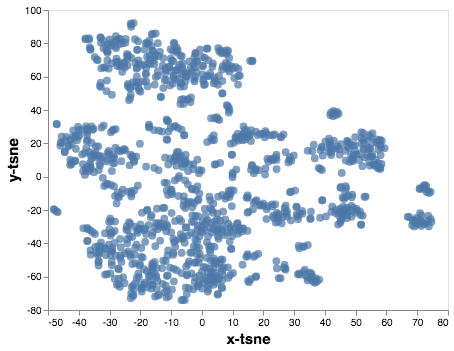

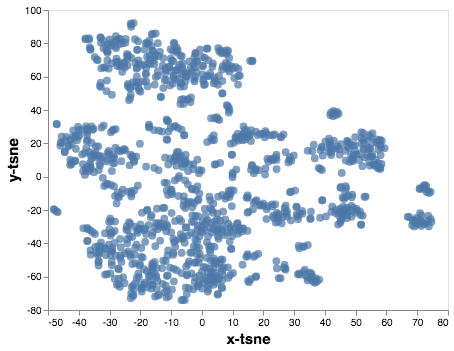

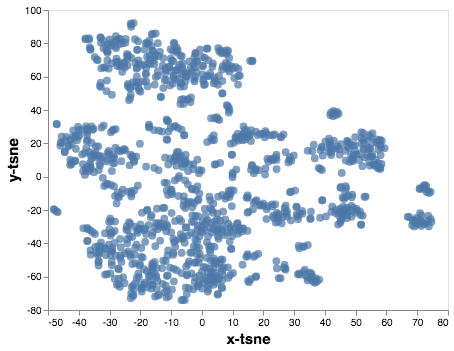

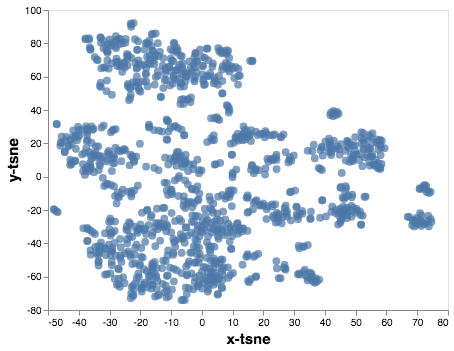

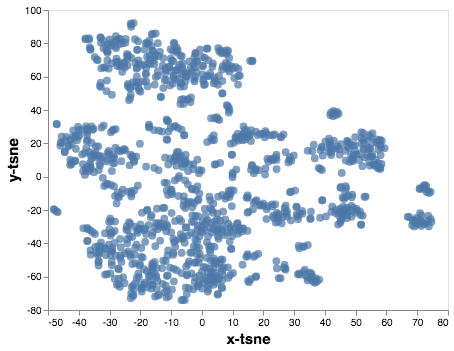

In [59]:
plot_brexit_tsne = alt.Chart(
    labelled_brexit[['x-tsne', 'y-tsne','title']]).mark_circle(size = 60).encode(
    alt.X('x-tsne:Q', axis = alt.Axis(grid = False)), 
    alt.Y('y-tsne:Q', axis = alt.Axis(grid = False)), 
    tooltip = ['title:N']
).configure_axis(titleFontSize = 15).interactive()

plot_brexit_tsne.display()

### Identifying clusters

### k means

k means is simple but isn't really appropriate here. We're trying to identify groups but don't know how many there might be in advance; k means requires you to pre-choose the number of groups. k means also categorises _all_ points, but we don't necessarily want to do this. Something like (H)DBSCAN can identify 'noise' or outliers points that don't belong to any particular group. k means also requirescompact and well-separated clusters, which we don't have. 

In [122]:
from sklearn.cluster import KMeans

In [123]:
brexit_pca_ax = labelled_brexit[['pca-one', 'pca-two']]  # axes from PCA

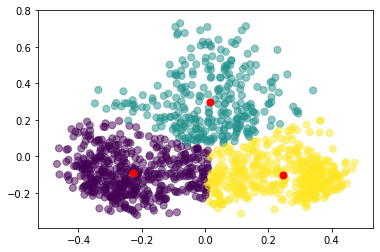

In [141]:
kmeans = KMeans(n_clusters=3).fit(brexit_pca_ax)  # fit to the data

centroids = kmeans.cluster_centers_  # isolate the centres for viz

# Visualise clusters in different colours
plt.scatter(brexit_pca_ax['pca-one'], brexit_pca_ax['pca-two'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

### DBSCAN

DBSCAN finds areas with a high density of observations and can deal with outliers, labelling them separately. It separates high density clsuters from low density clusters, but not so good where the high density clusters have different densities. There's also some limit to the number of dimensions that DBSCAN can work with. 

Following https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [182]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [183]:
db = DBSCAN(eps=0.3, min_samples=5).fit(brexit_embeddings)

In [184]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [185]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [186]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 1147


NameError: name 'labels_true' is not defined

In [193]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 750 but corresponding boolean dimension is 1179

### HDBSCAN

HDBSCAN is like DBSCAN but is hierarchical; extracting clusters by slicing the hierarchy

Code below following https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

In [142]:
import hdbscan

In [143]:
brexit_embeddings

array([[-0.01384636,  0.01715001,  0.03606272, ..., -0.01534817,
         0.01647961, -0.05993748],
       [-0.04563793,  0.04127745, -0.00644559, ..., -0.03332986,
         0.04976409, -0.06276609],
       [-0.01084065, -0.00611237, -0.01730281, ...,  0.00154343,
         0.05014637, -0.06256321],
       ...,
       [-0.04382474,  0.00842297,  0.0089147 , ..., -0.02628383,
         0.05491083, -0.05879661],
       [-0.00030151, -0.05320191,  0.03599082, ..., -0.04575277,
         0.01496796, -0.04728961],
       [-0.0412386 , -0.02751214,  0.03315298, ..., -0.0589726 ,
        -0.00737035, -0.06045217]], dtype=float32)

In [144]:
clusterer = hdbscan.HDBSCAN()

In [145]:
clusterer.fit(brexit_embeddings)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
label_list = clusterer.labels_.tolist()
embedding_list = brexit_embeddings.tolist()

In [181]:
clusterer.probabilities_.tolist()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9229623390270127,
 0.9425621722406043,
 1.0,
 1.0,
 0.9691091789767059,
 1.0,
 1.0,
 1.0,
 0.9248250550586983,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.9794662074669215,
 1.0,
 0.9183931326159843,
 1.0,
 0.9149534892286046,
 0.9458491183910216,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.9629234935539815,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9742307919405677,
 0.9596531123803123,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.9978274893274343,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9863532009906101,
 1.0,
 0.9524042076834042,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9640910238685845,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9362964537496103,
 0.8940147804683624,
 1.0,
 1.0,
 1.0,
 1.0,
 0.888035781238045,
 1.0,
 1.0,
 1.0,
 0.9036527084230204,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9319828291294973,
 1.0,
 0.9297815833836618,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9433284778764924,
 1.0,
 1.0,
 0.0,
 0.9738094037037027,
 1.0,
 1.0,
 1.0,
 0

In [155]:
from sklearn.datasets import make_blobs
blobs, labels = make_blobs(n_samples=2000, n_features=10)

In [150]:
test_clusterer = hdbscan.HDBSCAN()
test_clusterer.fit(blobs)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [151]:
test_clusterer.labels_

array([0, 0, 2, ..., 2, 1, 2])

In [152]:
test_clusterer.labels_.max()

2